# 第14章 パラメータ推定への応用と拡張（EKF）

In [11]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt

#### 乱数シードの指定（テキスト掲載用）
拙著に掲載の標本路を再現するため，シードを明示しておきます．本来は必要ないので，コメントアウトしてもいいです．

In [12]:
np.random.seed(123)

## 本章の共通設定

In [13]:
import Ch14_common as my
for line in open('Ch14_common.py'): print(line[:-1])

import numpy as np
import matplotlib.pyplot as plt

### デフォルト値
default_values = ( #Q, R, C, D, x0, dt, tn, p_list
    np.diag([0.0001,0.0001]), #Q:  システム雑音の共分散
    np.array([[0.0001]]),     #R:  観測雑音の共分散
    np.array([[1, 0]]),       #C:  変位のみ
    np.eye(2),                #D:  駆動行列
    np.array([0.0, 0.0]),     #x0: 初期値
    0.02,                     #dt: 時間ステップ
    2000,                     #tn: 時系列長
    [1, 0.2, 1],              #p_list: k, c, a
)

### 外部励振
def Forcing(t):
    return np.sin(1.5*t)

### 拡大系の導出
def get_extended_system(x0, Q, D, C, A=None, Qval=1.2):
        
    ex0 = np.append(x0, [0.0])
    # 拡大系
    if A is not None:
        eA = np.pad(A, (0,1), 'constant') #Aを1行1列拡大して0で埋める
        eA[-2,-1] = 1 #必要箇所に1を代入する
    else:
        eA = None
    # 推定パラメータにもシステム雑音を仮定（無いと推定パラメータが動かなくなる）
    eD = np.pad(D, (0,1), 'constant')
    eD[-1,-1] = 1
    # 推定パラメータは観測できないとする
    eC = np.pad(C, (0,1), 'constant')
    eC = np.delete(eC, axis=0, obj=-1)
    # 推定パラメータ用のシステム雑音強度を追加
    e

### 標本路の取得テスト

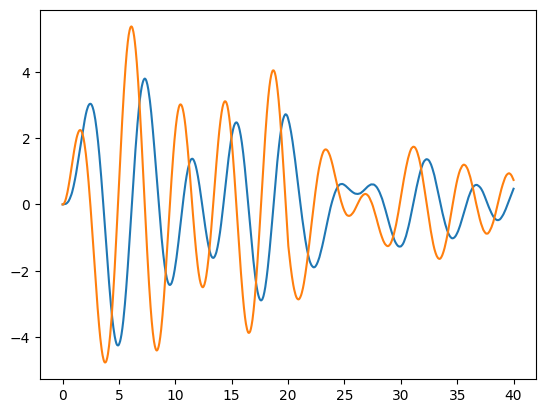

In [14]:
sim = my.model_1dof_tv(p_idx=2, p1=3, p2=1)
sim.get_sample_path()
plt.plot(sim.tt, sim.xx)

## 14.2 拡張カルマンフィルタ

### 算法14.1 (EKF)

In [15]:
from class_EKF import *
for line in open('class_EKF.py'): print(line[:-1])

import numpy as np
from scipy.linalg import solve_discrete_are

class class_EKF: #拡張カルマンフィルタ(Extended Kalman filter)
    
    def __init__(s, xdim, ydim, G, Q, R, x0, cov0=None):
        
        s.xdim = xdim #状態ベクトルの次元
        s.ydim = ydim #出力ベクトルの次元
        
        ### システム行列
        ### 状態推移行列 s.F は推定時に代入される
        ### 観測行列 s.H は推定時に代入される
        s.G = np.array(G) #駆動行列
        # 雑音
        s.Q = np.array(Q) #システム雑音の共分散行列
        s.R = np.array(R) #観測雑音の共分散行列
        
        ### フィルタの初期値
        s.xf = np.array(x0) #濾波推定値
        s.xp = np.array(x0) #予測推定値
        s.K  = None         #カルマンゲイン
        #共分散行列とその初期値
        if cov0 is not None:
            s.cov    = np.array(cov0)
        else:
            s.cov    = np.zeros((s.xdim,s.xdim))
            
    def recursion(s, yt, xp, cov, t): #yt:観測量, xp=x_t/t-1, cov=S_t/t-1
        
        H = s.H_jac(xp,t)                      #拡張 H_jac
        s.H = H
        
        HSH_R = H.dot(cov).dot(H.T)+s.R
        if HSH_R.ndim > 1:

### 数値例作成用のクラス

In [16]:
import matplotlib.gridspec as gsp
import time

class EKF_param(class_EKF):
    
    def __init__(s, x0, cov0, Qval):

        Q, R, C, D, _x0, dt, tn, p_list = my.default_values
        _x0, Q, D, C, = my.get_extended_system(_x0, Q, D, C, Qval=Qval)
        
        x0   = np.array(x0)   #初期状態
        cov0 = np.diag(cov0)  #初期誤差共分散
        xdim = len(x0);       #状態ベクトルの次元
        ydim = C.shape[0];    #出力ベクトルの次元
        s.dt = dt             #時間ステップ

        D *= np.sqrt(dt)      #離散時間近似(算法12.3)
        
        super().__init__(xdim, ydim, D, Q, R, x0, cov0)
        
        s.C = C
        s.p_list = p_list.copy()
                        
        s.k, s.c, s.a = s.p_list
        s.Imat = np.eye(xdim)
            
    def H_func(s, x, t):
        return s.C.dot(x)

    def H_jac(s, x, t):
        return s.C
    
    def get_example(s, p_idx, p1, p2):
        target = my.model_1dof_tv(p_idx, p1, p2)
        target.get_sample_path()
        s.tt = target.tt
        s.xx = target.xx
        s.param = target.param
        s.xxf = np.zeros((len(target.tt),3))
        s.pp = np.zeros(len(target.tt))
        
        start = time.time()
        for i, y in enumerate(target.yy):
            s.xxf[i] = s.xf
            s.filtering(y,t=s.tt[i])
        elapsed_time = time.time() - start
        
        s.stability()
        
        return elapsed_time

    def plot(s):
        fig = plt.figure(figsize=(4, 4))
        gs = gsp.GridSpec(2,2)
        ax1 = fig.add_subplot(gs[0,:])
        ax2 = fig.add_subplot(gs[1,0])
        ax3 = fig.add_subplot(gs[1,1])
    
        ax1.plot(s.tt, s.xxf[:,2], label='filtered'); ax1.grid()
        ax2.plot(s.xxf[:,0], s.xxf[:,1], label='filtered')
        ax2.plot(s.xx[:,0], s.xx[:,1], label='original')
        ax2.legend()
        plt.tight_layout()

In [17]:
Elapsed_Times = []

### 線形と同じaの同定

In [18]:
class EKF_a(EKF_param):
    
    def __init__(s, x0, cov0, Qval):
        super().__init__(x0, cov0, Qval)

    def F_func(s, x, t):
        ff = np.array([
            x[1],
            - s.k*x[0] - s.c*x[1] + x[2]*my.Forcing(t),
            0
        ])

        return x + s.dt*ff

    #ヤコビ行列にxの成分がない．すなわち，時変なだけで非線形ではない．
    #EKFのコードを流用してるだけで，普通の時変カルマンフィルタを解いてるのと同じ．
    def F_jac(s, x, t): 
        ff_jac = np.array([
            [0,       1, 0],
            [-s.k, -s.c, my.Forcing(t)],
            [0,       0, 0]
        ])

        return s.Imat + s.dt*ff_jac

    
np.random.seed(123)
ekf_a = EKF_a( x0=[0,0,0], cov0=[0.0001,0.0001,0.01], Qval=0.0006 )
etim = ekf_a.get_example(p_idx=2, p1=3, p2=1)
Elapsed_Times.append(etim)

Extended x0 =
 [0. 0. 0.]
Extended A =
 None
Extended D =
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Extended C =
 [[1 0 0]]
Extended Q =
 [[0.0001 0.     0.    ]
 [0.     0.0001 0.    ]
 [0.     0.     0.0006]]
This filter is unstable
> Eigenvalues:
> 0.8734109435459947
> 0.9621023286829496
> 1.00492584496826
> Their absolute values:
> 0.8734109435459947
> 0.9621023286829496
> 1.00492584496826


[[ 0.          0.          0.        ]
 [ 0.00498673  0.          0.        ]
 [ 0.00143119 -0.00016751  0.        ]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


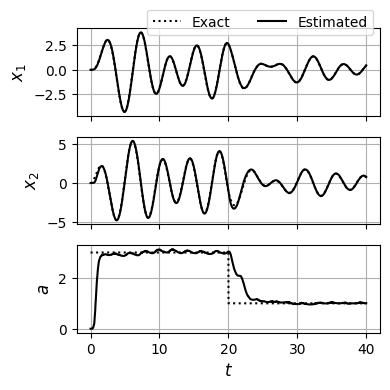

In [19]:
print(ekf_a.xxf[:3,:])
my.plot(ekf_a,'$a$')
my.save('figs/Ch14-EKF-a.eps')

### 線形では解けないkの同定

In [20]:
class EKF_k(EKF_param):
    
    def __init__(s, x0, cov0, Qval):
        super().__init__(x0, cov0, Qval)
    
    def F_func(s, x, t):
        ff = np.array([
            x[1],
            - (x[2])*x[0] - s.c*x[1] + s.a*my.Forcing(t),
            0
        ])

        return x + s.dt*ff
    
    def F_jac(s, x, t):
        ff_jac = np.array([
            [0,        1,     0],
            [-x[2], -s.c, -x[0]],
            [0,        0,     0]
        ])

        return s.Imat + s.dt*ff_jac

np.random.seed(123)
ekf_k = EKF_k( x0=[0,0,0], cov0=[0.0001,0.0001,0.01], Qval=0.0002)
etim = ekf_k.get_example(p_idx=0, p1=0.5, p2=1) #kを変化させる
Elapsed_Times.append(etim)

Extended x0 =
 [0. 0. 0.]
Extended A =
 None
Extended D =
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Extended C =
 [[1 0 0]]
Extended Q =
 [[0.0001 0.     0.    ]
 [0.     0.0001 0.    ]
 [0.     0.     0.0002]]
This filter is unstable
> Eigenvalues:
> 0.8726223975759883
> 0.9698701138201592
> 1.0045823409803891
> Their absolute values:
> 0.8726223975759883
> 0.9698701138201592
> 1.0045823409803891


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


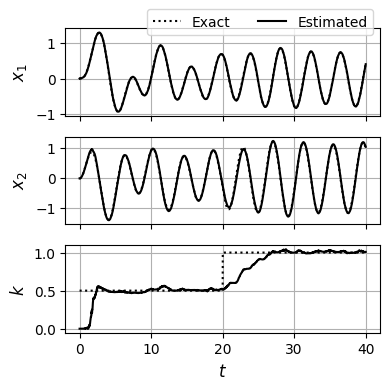

In [21]:
my.plot(ekf_k,'$k$')
my.save('figs/Ch14-EKF-k.eps')

### 線形では解けないｃの同定

In [22]:
class EKF_c(EKF_param):
    
    def __init__(s, x0, cov0, Qval):
        super().__init__(x0, cov0, Qval)
        
    def F_func(s, x, t):
        ff = np.array([
            x[1],
            - s.k*x[0] - (x[2])*x[1] + s.a*my.Forcing(t),
            0
        ])

        return x + s.dt*ff

    def F_jac(s, x, t):
        ff_jac = np.array([
            [0,        1,     0],
            [-s.k, -x[2], -x[1]],
            [0,        0,     0]
        ])

        return s.Imat + s.dt*ff_jac

np.random.seed(123)
ekf_c = EKF_c( x0=[0,0,0], cov0=[0.001,0.001,0.005], Qval=0.0004 ) 
etim = ekf_c.get_example(p_idx=1, p1=0.5, p2=1.0) #cを変化させる
Elapsed_Times.append(etim)

Extended x0 =
 [0. 0. 0.]
Extended A =
 None
Extended D =
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Extended C =
 [[1 0 0]]
Extended Q =
 [[0.0001 0.     0.    ]
 [0.     0.0001 0.    ]
 [0.     0.     0.0004]]
This filter is stable
> Eigenvalues:
> 0.8737791525780063
> 0.9596773681243314
> 0.9930011913199719
> Their absolute values:
> 0.8737791525780063
> 0.9596773681243314
> 0.9930011913199719


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


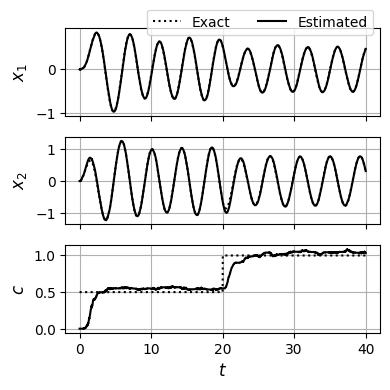

In [23]:
my.plot(ekf_c,'$c$')
my.save('figs/Ch14-EKF-c.eps')

In [24]:
print(Elapsed_Times)

[0.34667539596557617, 0.30871152877807617, 0.3796401023864746]
